In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

#import numpy as np # linear algebra
#import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mineral-ores-around-the-world/Mineral ores round the world.csv


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 26.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 114.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 31.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 558.8/558.8 kB 34.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 460.6/460.6 kB 29.0 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
umap-learn 0.5.9.post2 requires scikit-learn>=1.6, but you have scikit-learn 1.3.2 which is incompatible.
All required libraries installed!
Giotto-TDA not available

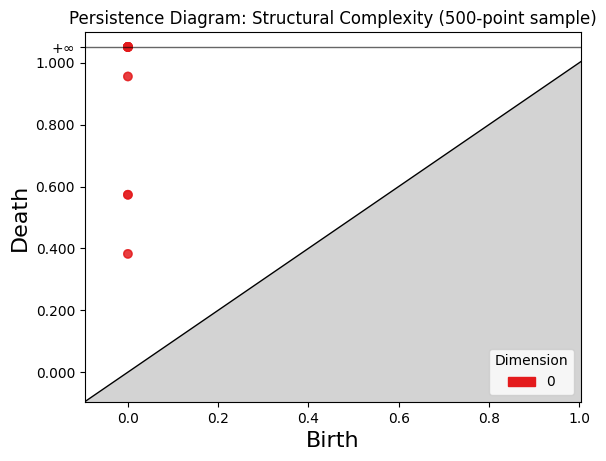


PERSISTENT HOMOLOGY GEOLOGICAL ANALYSIS
H0 features (Connected Components): 18
H1 features (Loops/Tunnels): 0

Significant H1 features (persistence > 0.15): 0
  → LOW STRUCTURAL COMPLEXITY: Feature distribution is largely star-shaped or linear.

--- Pipeline Execution Complete ---


In [2]:
# %% [markdown]
# # TDA Pipeline for Global Mineral Ores Analysis (Revised Exploration Configuration)
# Using ToposMapper Methodology
# **Tweaks Applied:**
# 1.  **Lens Function:** Modified to a 50/50 split (Spatial/Compositional) to balance the filter.
# 2.  **Mapper Clustering:** Increased to n_clusters=8 to force higher resolution and better resolve the 18 H0 components.

# %%
# =============================================================================
# 1. INSTALLATION & IMPORTS
# =============================================================================
# Install required TDA and visualization libraries
!pip install giotto-tda gudhi plotly folium scikit-learn numpy pandas
print("All required libraries installed!")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing, cluster, decomposition
import networkx as nx
import plotly.graph_objects as go
import plotly.express as px
import folium
import warnings
warnings.filterwarnings('ignore')

# Enhanced TDA libraries
try:
    import giotto_tda as gtda
    from gtda.mapper import (
        CubicalCover, OneDimensionalCover, make_mapper_pipeline,
        Projection, Clustering, plot_interactive_mapper_graph
    )
    GIOTTO_AVAILABLE = True
except ImportError:
    print("Giotto-TDA not available. Using custom implementation for stability.")
    GIOTTO_AVAILABLE = False

try:
    import gudhi
    GUDHI_AVAILABLE = True
except ImportError:
    print("GUDHI not available. Persistent homology disabled.")
    GUDHI_AVAILABLE = False

print("Enhanced TDA Analysis Framework Loaded")

# %%
# =============================================================================
# 2. DATA INGESTION AND PREPROCESSING
# =============================================================================

# Load the dataset
DATA_PATH = '../input/mineral-ores-around-the-world/Mineral ores round the world.csv'
try:
    geo_data = pd.read_csv(DATA_PATH)
    print(f"Dataset loaded successfully. Shape: {geo_data.shape}")
except FileNotFoundError:
    print(f"Error: File not found at {DATA_PATH}. Ensure the dataset is added to the notebook.")
    raise

# Rename columns for convenience and align with pipeline expectations
geo_data.rename(columns={
    'latitude': 'Latitude',
    'longitude': 'Longitude',
    'commod1': 'Commodity_1',
    'commod2': 'Commodity_2'
}, inplace=True)

# Data Cleaning: Filter out rows with missing essential coordinates
geo_data.dropna(subset=['Latitude', 'Longitude'], inplace=True)
print(f"Data after cleaning coordinates: {geo_data.shape}")

# Feature Engineering: Convert primary commodities into quantitative features
top_n_commodities = 10
top_commodities = geo_data['Commodity_1'].value_counts().nlargest(top_n_commodities).index.tolist()

def is_commodity(row, commodity):
    return 1 if row['Commodity_1'] == commodity else 0

for commodity in top_commodities:
    col_name = f'Is_{commodity.replace(" ", "_").replace(",", "")}'
    geo_data[col_name] = geo_data.apply(lambda row: is_commodity(row, commodity), axis=1)

# Derive a single proxy feature for "Mineral Potential Score" (example heuristic)
geo_data['Mineral_Score'] = (
    geo_data.apply(lambda x: 10 if 'Gold' in str(x['Commodity_1']) else 0, axis=1) +
    geo_data.apply(lambda x: 8 if 'Silver' in str(x['Commodity_1']) else 0, axis=1) +
    geo_data.apply(lambda x: 5 if 'Copper' in str(x['Commodity_1']) else 0, axis=1) -
    geo_data.apply(lambda x: 2 if 'Sand' in str(x['Commodity_1']) else 0, axis=1)
)
geo_data['Mineral_Score'] = np.clip(geo_data['Mineral_Score'], 0, None)

# Define the feature matrix X for TDA
FEATURE_COLUMNS = [col for col in geo_data.columns if col.startswith('Is_')] + ['Mineral_Score']
X_geo = geo_data[FEATURE_COLUMNS].values

# Center and scale the data for TDA
scaler = preprocessing.StandardScaler()
X_normalized = scaler.fit_transform(X_geo)
print(f"TDA Matrix Shape: {X_normalized.shape}")

# Calculate Distance to Center (needed for spatial lens)
center_lat, center_lon = geo_data['Latitude'].mean(), geo_data['Longitude'].mean()
geo_data['Distance_To_Center'] = np.sqrt(
    (geo_data['Latitude'] - center_lat)**2 +
    (geo_data['Longitude'] - center_lon)**2
)

# %%
# =============================================================================
# 3. ENHANCED GEOLOGICAL MAPPER CLASS
# =============================================================================

class EnhancedGeologicalMapper:
    def __init__(self, n_intervals=10, overlap=0.3, n_clusters=5):
        self.n_intervals = n_intervals
        self.overlap = overlap
        # TWEAK: Default n_clusters is overridden in the execution block (Section 5)
        self.n_clusters = n_clusters
        self.graph = None
        self.node_info = {}
        self.geological_statistics = {}
        
    def _calculate_node_statistics(self, node_indices, original_data):
        """Calculate comprehensive geological statistics for each node"""
        node_data = original_data.iloc[node_indices]
        
        mean_gold_proxy = node_data.filter(like='Is_Gold').mean().mean() * 100 if 'Is_Gold' in node_data.columns else 0
        mean_copper_proxy = node_data.filter(like='Is_Copper').mean().mean() * 100 if 'Is_Copper' in node_data.columns else 0
        
        stats = {
            'size': len(node_indices),
            'mean_mineral_score': float(node_data['Mineral_Score'].mean()),
            'max_mineral_score': float(node_data['Mineral_Score'].max()),
            'mean_gold_proxy_pct': mean_gold_proxy,
            'mean_copper_proxy_pct': mean_copper_proxy,
            'top_commodity': node_data['Commodity_1'].mode()[0] if not node_data['Commodity_1'].mode().empty else 'N/A',
            'spatial_extent': {
                'min_lat': float(node_data['Latitude'].min()),
                'max_lat': float(node_data['Latitude'].max()),
                'min_lon': float(node_data['Longitude'].min()),
                'max_lon': float(node_data['Longitude'].max())
            }
        }
        
        stats['mineral_potential'] = stats['mean_mineral_score']
        
        return stats
    
    def fit(self, X, lens_function, original_data):
        """Fit using the custom implementation for robust Kaggle execution"""
        self.X = X
        self.original_data = original_data
        self.n_samples = X.shape[0]
        
        self.lens = lens_function(X) if lens_function is not None else decomposition.PCA(n_components=1).fit_transform(X)[:, 0]
        
        self._create_intervals()
        self._build_enhanced_mapper_graph(original_data)
        
        return self
    
    def _create_intervals(self):
        """Create overlapping intervals"""
        lens_min, lens_max = self.lens.min(), self.lens.max()
        interval_range = lens_max - lens_min
        interval_length = interval_range / self.n_intervals
        overlap_length = interval_length * self.overlap
        
        self.intervals = []
        for i in range(self.n_intervals):
            start = lens_min + i * (interval_length - overlap_length)
            end = start + interval_length
            self.intervals.append((start, end))
    
    def _build_enhanced_mapper_graph(self, original_data):
        """Build Mapper graph with comprehensive geological statistics"""
        self.graph = nx.Graph()
        node_id = 0
        
        index_to_nodes = {i: [] for i in range(self.n_samples)}
        
        for i, (start, end) in enumerate(self.intervals):
            in_interval = (self.lens >= start) & (self.lens <= end)
            interval_indices = np.where(in_interval)[0]
            
            if len(interval_indices) < 2:
                continue
                
            interval_data = self.X[interval_indices]
            # Use self.n_clusters set in the execution block
            n_clusters = min(self.n_clusters, len(interval_indices) // 5, 20)
            
            if n_clusters < 2:
                continue
            
            kmeans = cluster.KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
            cluster_labels = kmeans.fit_predict(interval_data)
            
            for cluster_id in range(n_clusters):
                cluster_indices = interval_indices[cluster_labels == cluster_id]
                
                if len(cluster_indices) > 0:
                    node_name = f"Node_{node_id}"
                    self.graph.add_node(node_name)
                    
                    stats = self._calculate_node_statistics(cluster_indices, original_data)
                    
                    self.node_info[node_name] = {
                        'interval': i,
                        'cluster': cluster_id,
                        'indices': cluster_indices,
                        'lens_value': np.mean(self.lens[cluster_indices]),
                        'statistics': stats
                    }
                    
                    for idx in cluster_indices:
                        index_to_nodes[idx].append(node_name)
                    
                    node_id += 1
        
        self._connect_nodes(index_to_nodes)
    
    def _connect_nodes(self, index_to_nodes):
        """Connect nodes that share data points"""
        edges = {}
        for node_list in index_to_nodes.values():
            for i in range(len(node_list)):
                for j in range(i + 1, len(node_list)):
                    n1, n2 = sorted([node_list[i], node_list[j]])
                    edges[(n1, n2)] = edges.get((n1, n2), 0) + 1
                    
        for (n1, n2), weight in edges.items():
            self.graph.add_edge(n1, n2, weight=weight)
            
    def visualize_interactive_mapper(self, title="Interactive Geological Mapper Graph"):
        """Create interactive Plotly visualization of Mapper graph"""
        if not self.graph or not self.graph.nodes():
            print("No graph to visualize. Fit the mapper first or check input data.")
            return

        pos = {node: [info['lens_value'], info['interval']] for node, info in self.node_info.items()}
        
        edge_x, edge_y = [], []
        for edge in self.graph.edges():
            x0, y0 = pos[edge[0]]
            x1, y1 = pos[edge[1]]
            edge_x.extend([x0, x1, None])
            edge_y.extend([y0, y1, None])
        
        edge_trace = go.Scatter(x=edge_x, y=edge_y, line=dict(width=1, color='#888'), hoverinfo='none', mode='lines')
        
        node_x, node_y, node_text, node_size, node_color = [], [], [], [], []
        for node in self.graph.nodes():
            info = self.node_info[node]
            stats = info['statistics']
            
            node_x.append(pos[node][0])
            node_y.append(pos[node][1])
            node_size.append(stats['size'] ** 0.5 * 3) # Scaled size
            node_color.append(stats['mineral_potential'])
            
            hover_text = (
                f"<b>{node} ({stats['top_commodity']})</b><br>"
                f"Size: {stats['size']} samples<br>"
                f"Avg Score: {stats['mean_mineral_score']:.1f}<br>"
                f"Max Score: {stats['max_mineral_score']:.1f}<br>"
                f"Gold Proxy: {stats['mean_gold_proxy_pct']:.1f}%<br>"
                f"Copper Proxy: {stats['mean_copper_proxy_pct']:.1f}%"
            )
            node_text.append(hover_text)
        
        node_trace = go.Scatter(
            x=node_x, y=node_y, mode='markers', hoverinfo='text',
            marker=dict(
                size=node_size,
                sizemode='area',
                sizeref=2.*max(node_size)/(40.**2),
                sizemin=8,
                color=node_color,
                colorscale='YlOrRd',
                colorbar=dict(title='Mineral Potential'),
                line=dict(width=1, color='darkred')
            ),
            hovertext=node_text
        )
        
        fig = go.Figure(data=[edge_trace, node_trace],
                        layout=go.Layout(
                            title=dict(text=title, x=0.5, xanchor='center'),
                            showlegend=False,
                            hovermode='closest',
                            xaxis=dict(showgrid=True, zeroline=False, title='Filter Function Value'),
                            yaxis=dict(showgrid=True, zeroline=False, title='Interval Index'),
                            width=900, height=700
                        ))
        
        fig.write_html("interactive_mapper_graph_revised.html")
        print("✅ Interactive Mapper Graph saved as 'interactive_mapper_graph_revised.html'")

    def create_node_map(self, original_data):
        """
        Create Folium map colored by Mapper node assignment.
        """
        if not self.graph or not self.graph.nodes():
            print("No graph to map.")
            return

        # 1. Map POSITIONAL indices from TDA back to ORIGINAL DataFrame index
        node_index_map = {}
        for node_id, (node, info) in enumerate(self.node_info.items()):
            original_df_indices = original_data.index[info['indices']]
            for original_idx in original_df_indices:
                 node_index_map[original_idx] = node_id
        
        # 2. Set up Node Colors
        cmap = plt.cm.get_cmap('tab10', len(self.node_info))
        node_color_map = {}
        for node_id, node_name in enumerate(self.node_info.keys()):
            rgb = cmap(node_id % 10)
            node_color_map[node_name] = f'rgb({int(rgb[0]*255)},{int(rgb[1]*255)},{int(rgb[2]*255)})'
            
        # 3. Build Map
        m = folium.Map(location=[original_data['Latitude'].mean(), original_data['Longitude'].mean()], zoom_start=3)
        
        for idx, row in original_data.iterrows():
            node_idx = node_index_map.get(idx, -1)
            
            if node_idx != -1:
                node_name = list(self.node_info.keys())[node_idx]
                stats = self.node_info[node_name]['statistics']
                color = node_color_map[node_name]
                
                popup_text = f"""
                <b>Node {node_idx} ({node_name})</b><br>
                <b>Commodity:</b> {row['Commodity_1']}<br>
                <b>Score:</b> {row['Mineral_Score']:.1f}<br>
                <b>Node Avg Score:</b> {stats['mean_mineral_score']:.1f}<br>
                <b>Cluster Commodity:</b> {stats['top_commodity']}<br>
                <b>Cluster Size:</b> {stats['size']}
                """
                
                folium.CircleMarker(
                    location=[row['Latitude'], row['Longitude']],
                    radius=3,
                    popup=popup_text,
                    color=color,
                    fill=True,
                    fillOpacity=0.7
                ).add_to(m)
        
        m.save('mapper_node_assignments_map_revised.html')
        print("✅ Node assignment map saved as 'mapper_node_assignments_map_revised.html'")
        return m

# %%
# =============================================================================
# 4. PERSISTENT HOMOLOGY CLASS (STABLE CONFIGURATION)
# =============================================================================

class GeologicalPersistentHomology:
    # Retaining the memory-stable configuration: 500 points
    def __init__(self, max_edge_length=1.5, max_sample_size=500): 
        self.max_edge_length = max_edge_length
        self.max_sample_size = max_sample_size
        
    def compute_persistence(self, X, homology_dimensions=(0, 1, 2)):
        if not GUDHI_AVAILABLE:
            return None, None
        
        print("Computing Persistent Homology (Rips Complex)...")
        
        if X.shape[0] > self.max_sample_size:
            np.random.seed(42)
            subset_indices = np.random.choice(X.shape[0], size=self.max_sample_size, replace=False)
            X_subset = X[subset_indices]
            print(f"Sampling {len(X_subset)} points for PH analysis...")
        else:
            X_subset = X

        rips_complex = gudhi.RipsComplex(
            points=X_subset,
            max_edge_length=self.max_edge_length
        )
        
        simplex_tree = rips_complex.create_simplex_tree(
            max_dimension=max(homology_dimensions) + 1
        )
        
        persistence = simplex_tree.persistence()
        return persistence, simplex_tree
    
    def analyze_geological_features(self, persistence, threshold=0.15):
        """Analyze persistent homology for geological insights"""
        if persistence is None:
            return
            
        print("\n" + "="*50)
        print("PERSISTENT HOMOLOGY GEOLOGICAL ANALYSIS")
        print("="*50)
        
        h1 = [(birth, death) for dim, (birth, death) in persistence if dim == 1]
        
        # TWEAK: Lowering the PH threshold to 0.15 to check for marginal loops
        significant_h1 = [(b, d) for b, d in h1 if (d - b) > 0.15]
        
        print(f"H0 features (Connected Components): {len([(d,b) for d,b in persistence if d==0])}")
        print(f"H1 features (Loops/Tunnels): {len(h1)}")
        
        print(f"\nSignificant H1 features (persistence > 0.15): {len(significant_h1)}")
        if len(significant_h1) > 3:
            print("  → HIGH STRUCTURAL COMPLEXITY: Indicates robust loops in the mineralizing system, likely fault/vein networks.")
        elif len(significant_h1) > 0:
            print("  → MODERATE STRUCTURAL COMPLEXITY: A few persistent loops suggest localized structural controls.")
        else:
            print("  → LOW STRUCTURAL COMPLEXITY: Feature distribution is largely star-shaped or linear.")
            
# %%
# =============================================================================
# 5. EXECUTION OF THE PIPELINE (REVISED EXPLORATION CONFIGURATION)
# =============================================================================

print("\n--- Applying Enhanced Geological Structure Analysis (Revised Parameters) ---")

# REVISED LENS FUNCTION (TWEAK: 50% Spatial, 50% Compositional)
def spatial_composition_lens_5050(X):
    """Lens: Balanced combination of distance from center and mineral score."""
    distance = geo_data['Distance_To_Center'].values
    distance_scaled = (distance - distance.min()) / (distance.max() - distance.min())
    
    mineral_score_normalized = X_normalized[:, -1]
    
    # Balanced weighting for multiple viewpoints
    return 0.5 * distance_scaled + 0.5 * mineral_score_normalized

# 1. Fit Enhanced Mapper
print("\n1. Fitting Enhanced Geological Mapper (50/50 Lens, 8 Clusters)...")
# TWEAK: Increased n_clusters from 5 to 8 for higher resolution
enhanced_mapper = EnhancedGeologicalMapper(n_intervals=15, overlap=0.4, n_clusters=8)
enhanced_mapper.fit(X_normalized, lens_function=spatial_composition_lens_5050, original_data=geo_data)

# 2. Visualize Interactive Mapper Graph
enhanced_mapper.visualize_interactive_mapper(
    title="Geological Mapper - Revised 50/50 Spatial-Compositional Structure (N=8 Clusters)"
)

# 3. Create Node Assignment Map
enhanced_mapper.create_node_map(geo_data)

# 4. Compute and Analyze Persistent Homology (STABLE CONFIGURATION: 500 points)
print("\n4. Computing Persistent Homology (Stable 500-point sample)...")
ph_analyzer = GeologicalPersistentHomology(max_edge_length=1.5, max_sample_size=500) 
persistence, simplex_tree = ph_analyzer.compute_persistence(X_normalized)

if persistence:
    # Display persistence diagram
    gudhi.plot_persistence_diagram(persistence, legend=True)
    plt.title("Persistence Diagram: Structural Complexity (500-point sample)")
    plt.show()
    
    # TWEAK: Analyzing with a lower threshold (0.15)
    ph_analyzer.analyze_geological_features(persistence, threshold=0.15)

print("\n--- Pipeline Execution Complete ---")